In [41]:
from datasets import get_dataset

from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np

from synthcity.plugins.models.time_to_event.loader import get_model_template
from synthcity.plugins import Plugins
from synthcity.utils.serialization import dataframe_hash, load_from_file, save_to_file
from lifelines import KaplanMeierFitter
import string
from synthcity.plugins.models.survival_analysis.metrics import nonparametric_distance

out_dir = Path("workspace")
fontsize = 14
plt.style.use("seaborn-whitegrid")
#plt.style.use("ggplot")

 
def generate_score(metric: np.ndarray) -> tuple:
    percentile_val = 1.96
    score = (np.mean(metric), percentile_val * np.std(metric) / np.sqrt(len(metric)))
 
    return round(score[0], 4), round(score[1], 4)
 
 
def generate_score_str(metric: np.ndarray) -> str:
    mean, std = generate_score(metric)
    return str(mean) + " +/- " + str(std)

    
def map_models(model):
    return {
        "survival_gan": "SurvivalGAN", 
        "adsgan": "AdsGAN", 
        "ctgan": "CTGAN", 
        "tvae": "TVAE", 
        "privbayes": "PrivBayes", 
        "nflow": "nFlows"
    }[model]

def plot_km(
    ax,
    title,
    T: pd.Series,
    E: pd.Series,
    syn_T: pd.Series,
    syn_E: pd.Series,
    ci_show: bool = True,
    ci_alpha: float = 0.2,
    show_censors: bool = False,
    syn_label: str = None,
    xaxis_label: str = None,
    yaxis_label: str = None,
    show_title: bool = True,
) -> None:
    gt_kmf = KaplanMeierFitter()
    gt_kmf.fit(T, E, label="Real data")  # t = Timepoints, Rx: 0=censored, 1=event
    ax = gt_kmf.plot(ax = ax, ci_show=ci_show, ci_alpha=ci_alpha, show_censors=show_censors)

    if syn_label is None:
        syn_label = "Synthetic data"
        
    syn_kmf = KaplanMeierFitter()
    syn_kmf.fit(
        syn_T, syn_E, label=syn_label
    )  # t = Timepoints, Rx: 0=censored, 1=event
    ax = syn_kmf.plot(
        ax=ax, ci_show=ci_show, ci_alpha=ci_alpha, show_censors=show_censors
    )
    ax.axvline(T[E == 1].max(), color="r", linestyle="--")  # vertical
    if show_title:
        ax.set_xlabel(title, horizontalalignment="center")
    else:
        ax.set_xlabel("Days", horizontalalignment="center")
    
    if yaxis_label is None:
        yaxis_label = "Temporal fidelity(Kaplan-Meier)"
    ax.set_ylabel(yaxis_label, fontsize = 20)

 
def plot_grouped_km(
    dataset: str,
    models: list,
    individual: bool = False,
    ci_show: bool = True,
    ci_alpha: float = 0.2,
    save: bool = False,
    **kwargs,
):
    df, duration_col, event_col, time_horizons = get_dataset(dataset)
    df_hash = dataframe_hash(df)
    
        
    results = {}
    for repeat_id in range(5):

        model_bkp = (
            out_dir
            / f"{df_hash}_survival_gan_{repeat_id}.bkp"
        )
        if not model_bkp.exists():
            continue

        fig, axs = plt.subplots(1, len(models), figsize = (5 * len(models), 4))

        for idx, model in enumerate(models):
            if model not in results:
                results[model] = {
                    "opt": [],
                    "abs_opt": [],
                    "sight": [],
                }
            model_bkp = (
                out_dir
                / f"{df_hash}_{model}_{repeat_id}.bkp"
            )
            if model_bkp.exists():
                syn_df = load_from_file(model_bkp)
            else:
                continue


            auc_opt, auc_abs_opt, sightedness = nonparametric_distance((df[duration_col], df[event_col]),
                                                        (syn_df[duration_col], syn_df[event_col]),
                                                       )
            results[model]["opt"].append(auc_opt)    
            results[model]["abs_opt"].append(auc_abs_opt)   
            results[model]["sight"].append(sightedness)
            plot_km(axs[idx], 
                    map_models(model), 
                    df[duration_col], 
                    df[event_col], 
                    syn_df[duration_col], 
                    syn_df[event_col],
                    syn_label = f"Synthetic model: {map_models(model)}",
                    show_title = True,
                    yaxis_label = f"Seed {repeat_id}"
                   )

        if save:
            plt.savefig(f"diagrams/grouped_kmplot_synth_gen_{dataset}_{model}_{repeat}.pdf")
        plt.show()
        
    cols = ["model", "opt", "abs_opt", "sight"]
    out = pd.DataFrame([], columns = cols)
    for model in results:
        local = [model]
        for metric in results[model]:
            local.append(generate_score_str(results[model][metric]))
        out = out.append(pd.DataFrame([local], columns = cols))
    return out



In [42]:
baseline_models = ["survival_gan", "adsgan", "ctgan", "tvae", "privbayes", "nflow"]

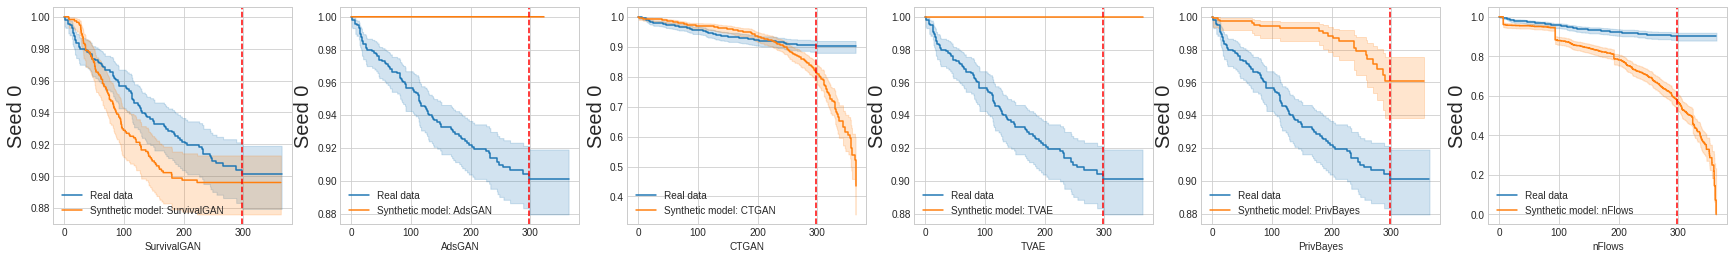

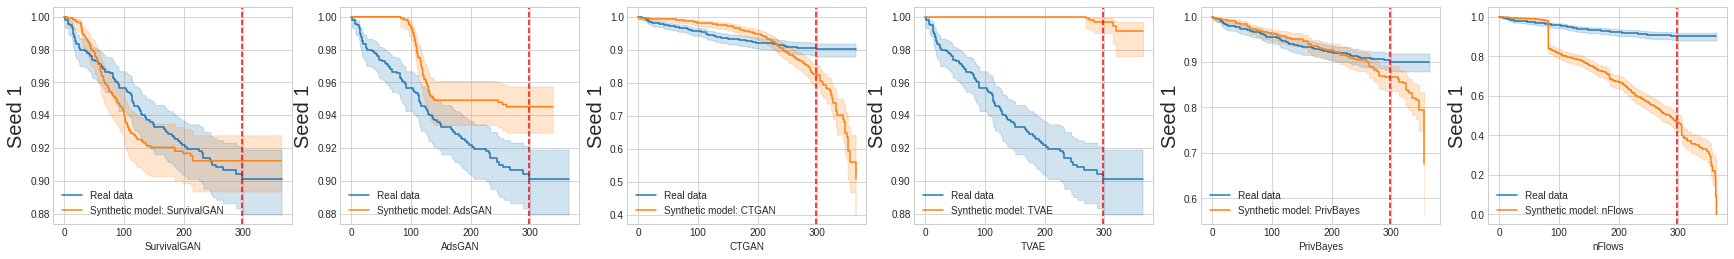

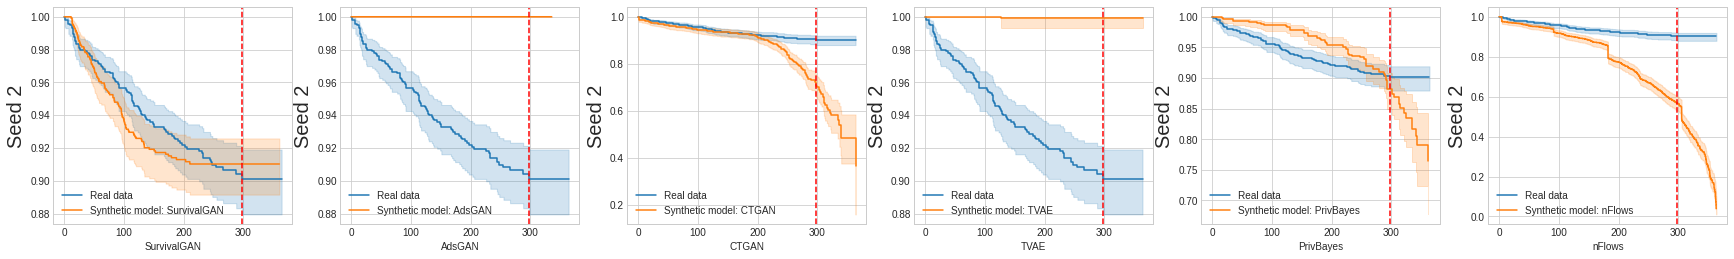

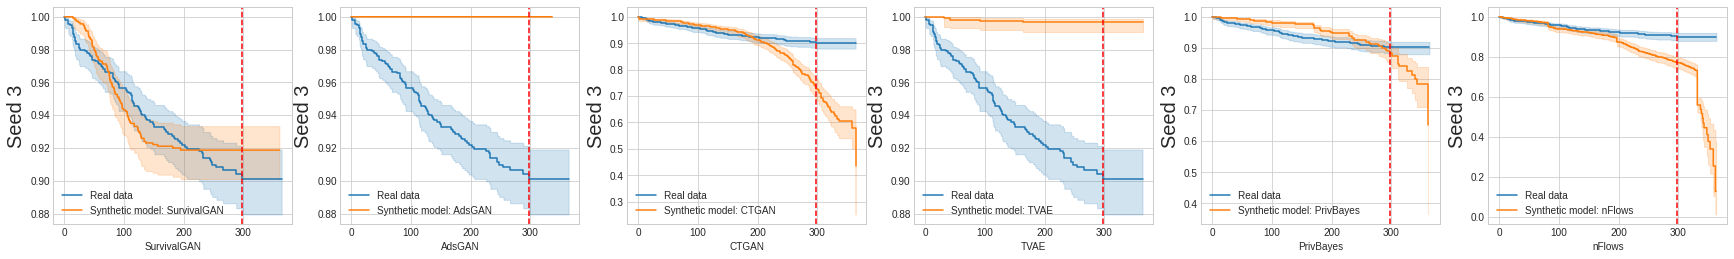

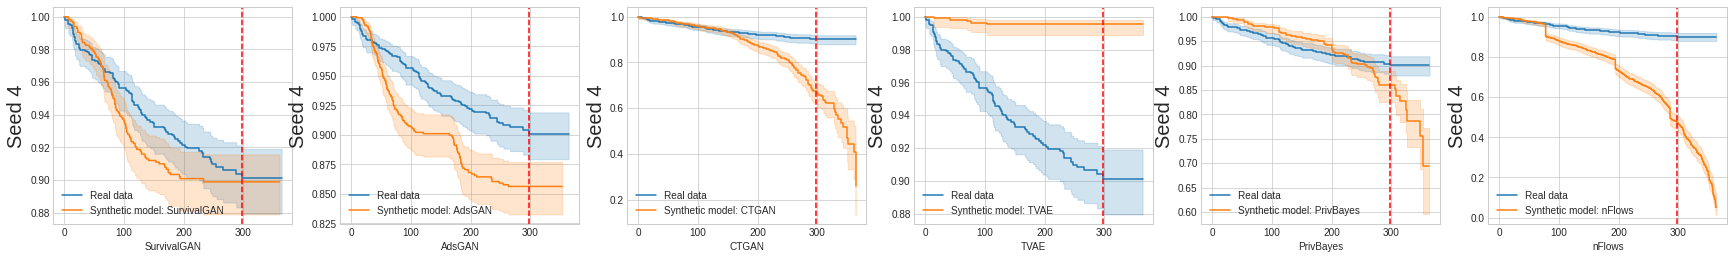

,model,opt,abs_opt,sight
0,survival_gan,-0.012 +/- 0.0053,0.0112 +/- 0.0019,0.0072 +/- 0.003
0,adsgan,-0.0368 +/- 0.0193,0.0491 +/- 0.0133,0.0805 +/- 0.0271
0,ctgan,-0.0612 +/- 0.0235,0.0739 +/- 0.0149,0.0 +/- 0.0
0,tvae,0.0643 +/- 0.0012,0.0639 +/- 0.0013,0.0 +/- 0.0
0,privbayes,-0.005 +/- 0.0166,0.0338 +/- 0.0085,0.0129 +/- 0.0101
0,nflow,-0.1839 +/- 0.047,0.1846 +/- 0.0485,0.0007 +/- 0.0006


In [43]:
plot_grouped_km(
            "aids", models=baseline_models, repeat_id = repeat, save = True
        )

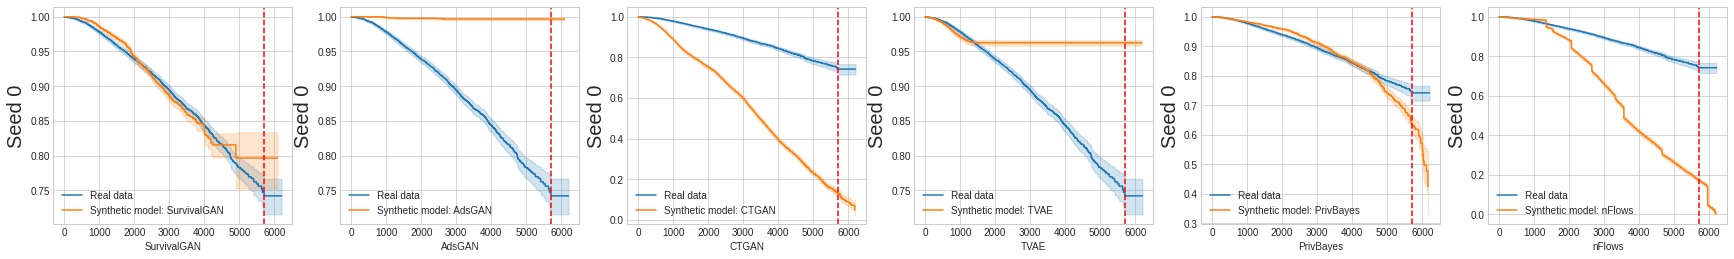

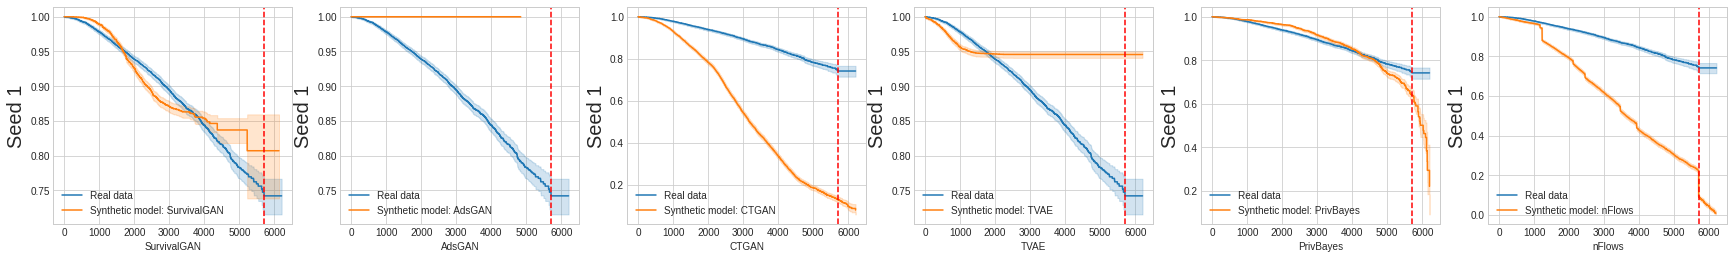

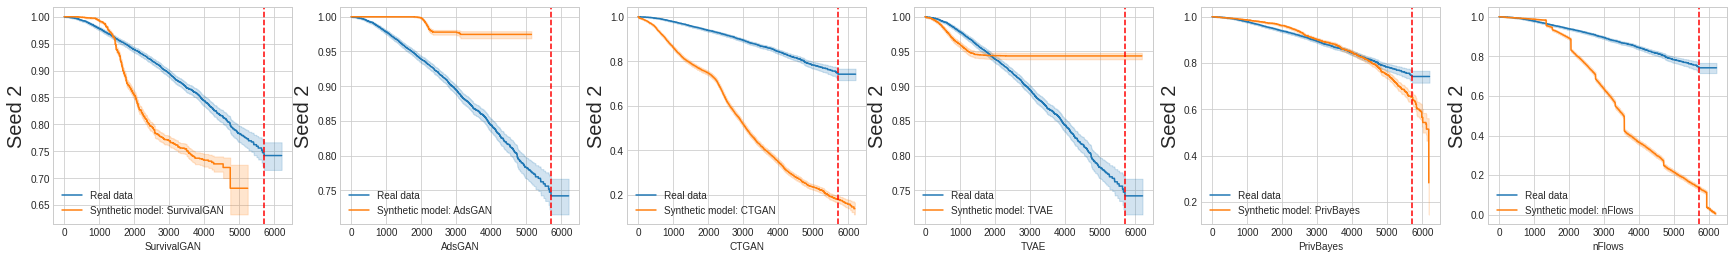

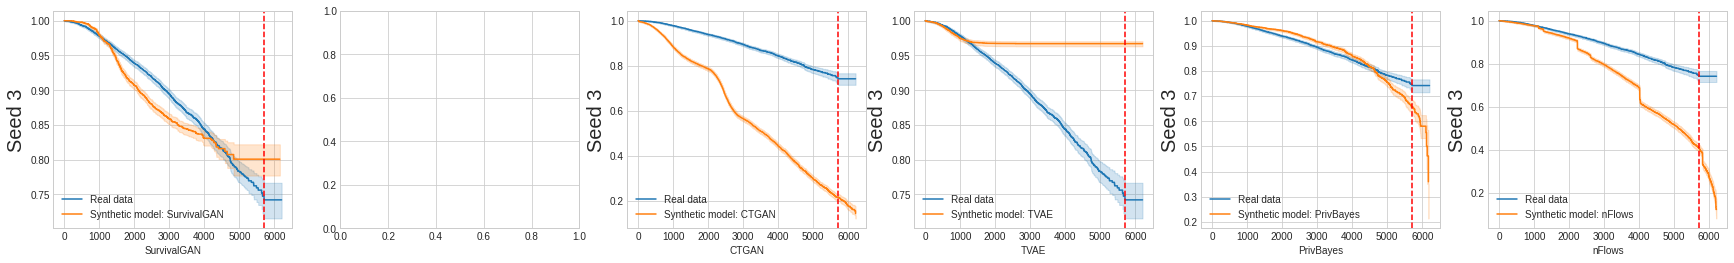

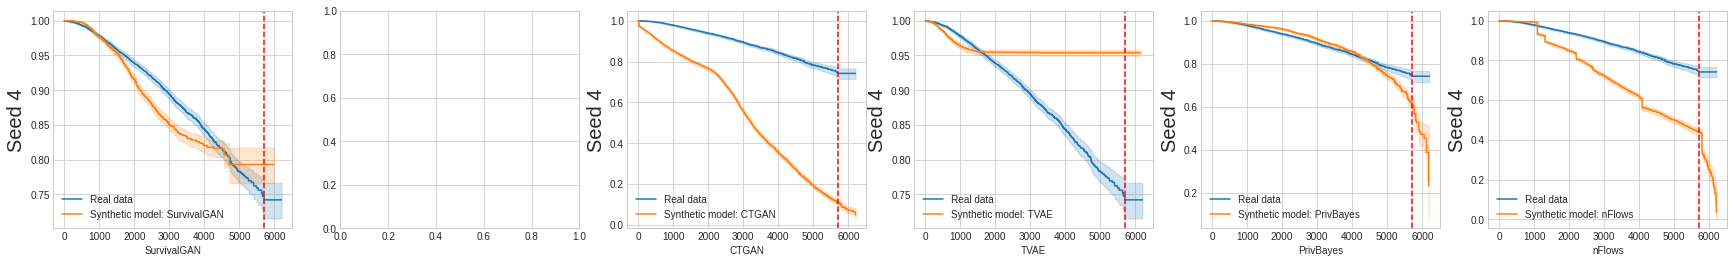

,model,opt,abs_opt,sight
0,survival_gan,-0.0524 +/- 0.0706,0.0308 +/- 0.0201,0.0523 +/- 0.0587
0,adsgan,-0.0352 +/- 0.1112,0.092 +/- 0.0183,0.1693 +/- 0.1254
0,ctgan,-0.3342 +/- 0.017,0.3332 +/- 0.0168,0.0013 +/- 0.0014
0,tvae,0.0767 +/- 0.0078,0.083 +/- 0.0049,0.0031 +/- 0.0029
0,privbayes,-0.0188 +/- 0.0033,0.0336 +/- 0.0041,0.0038 +/- 0.0021
0,nflow,-0.237 +/- 0.0556,0.2366 +/- 0.0546,0.002 +/- 0.0014


In [44]:
plot_grouped_km(
            "cutract", models=baseline_models, repeat_id = repeat, save = True
        )

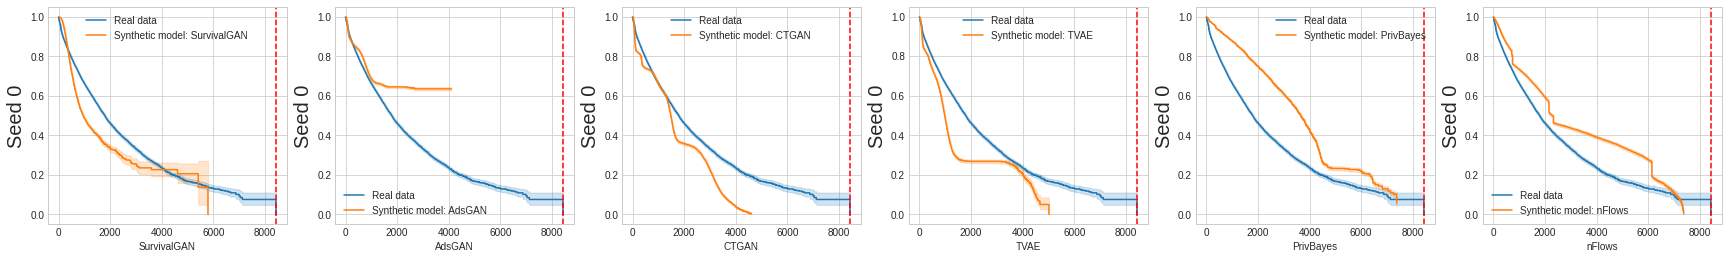

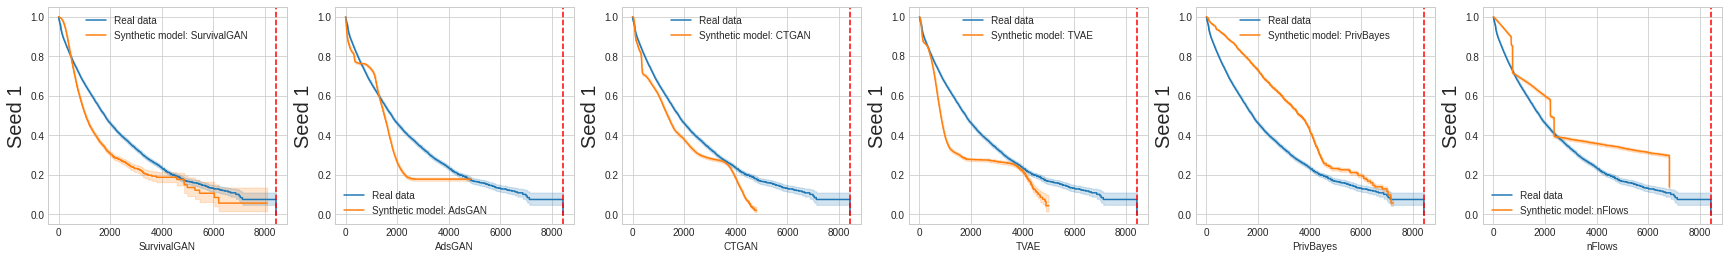

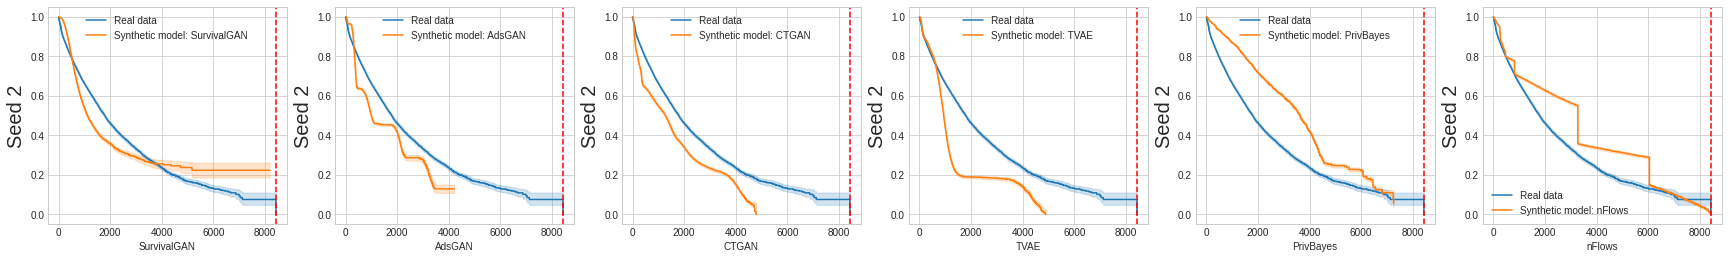

,model,opt,abs_opt,sight
0,survival_gan,-0.0458 +/- 0.0583,0.0767 +/- 0.007,0.1757 +/- 0.2239
0,adsgan,-0.1007 +/- 0.1324,0.127 +/- 0.0477,0.9293 +/- 0.1586
0,ctgan,-0.174 +/- 0.0219,0.0935 +/- 0.0191,0.7806 +/- 0.0375
0,tvae,-0.1967 +/- 0.0291,0.129 +/- 0.0274,0.6957 +/- 0.0224
0,privbayes,0.145 +/- 0.0051,0.1523 +/- 0.0042,0.1563 +/- 0.0107
0,nflow,0.0976 +/- 0.0053,0.1045 +/- 0.0095,0.1265 +/- 0.1095


In [45]:
plot_grouped_km(
            "maggic", models=baseline_models, repeat_id = repeat, save = True
        )

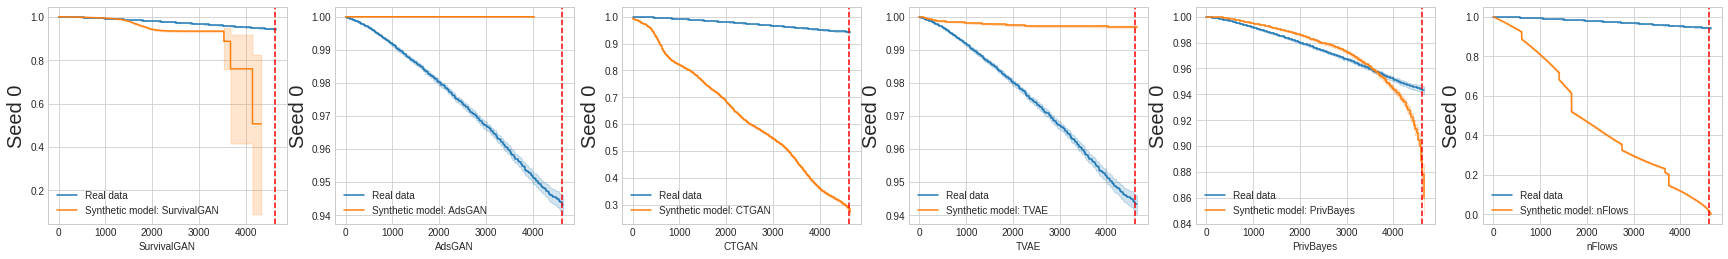

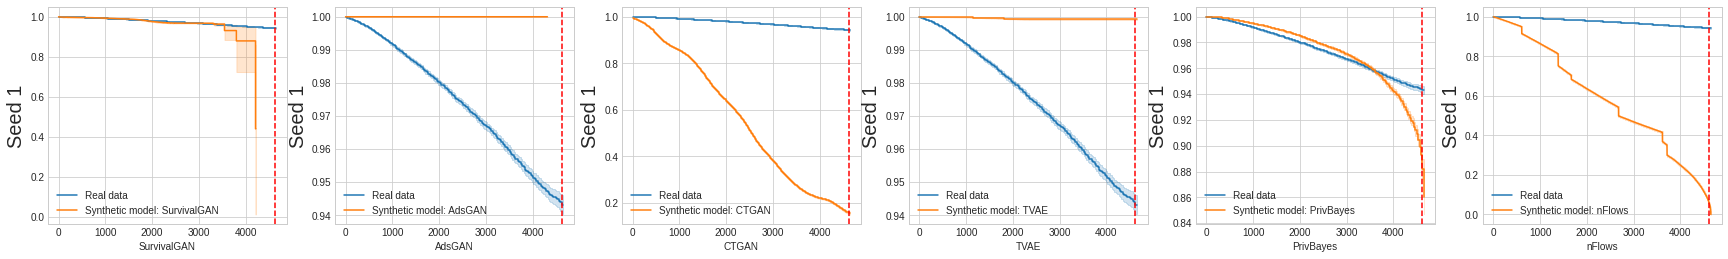

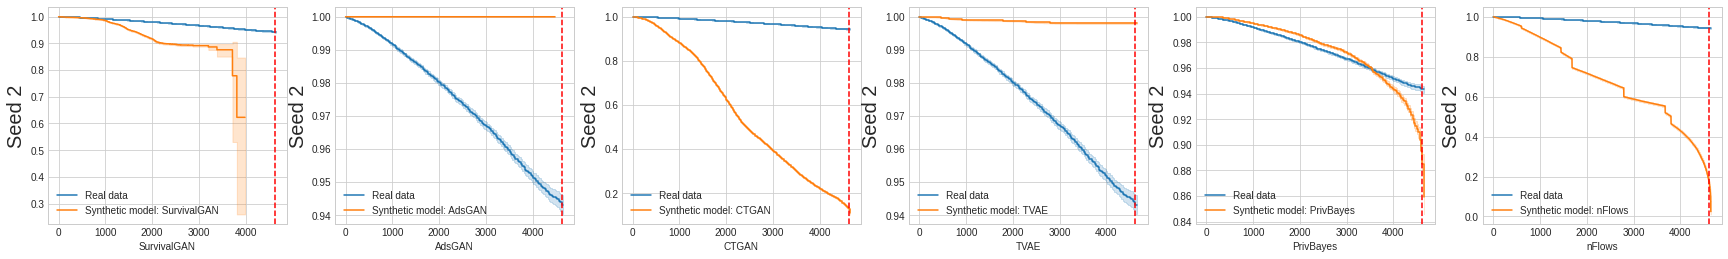

,model,opt,abs_opt,sight
0,survival_gan,-0.1535 +/- 0.0534,0.0442 +/- 0.0252,0.1135 +/- 0.0443
0,adsgan,-0.061 +/- 0.052,0.0229 +/- 0.0015,0.0889 +/- 0.0534
0,ctgan,-0.3867 +/- 0.0378,0.3861 +/- 0.0377,0.0 +/- 0.0
0,tvae,0.0242 +/- 0.0008,0.0241 +/- 0.0008,0.0 +/- 0.0
0,privbayes,-0.0012 +/- 0.0004,0.0066 +/- 0.0002,0.0 +/- 0.0
0,nflow,-0.3916 +/- 0.0953,0.3921 +/- 0.0953,0.0001 +/- 0.0


In [46]:
plot_grouped_km(
            "seer", models=baseline_models, repeat_id = repeat, save = True
        )